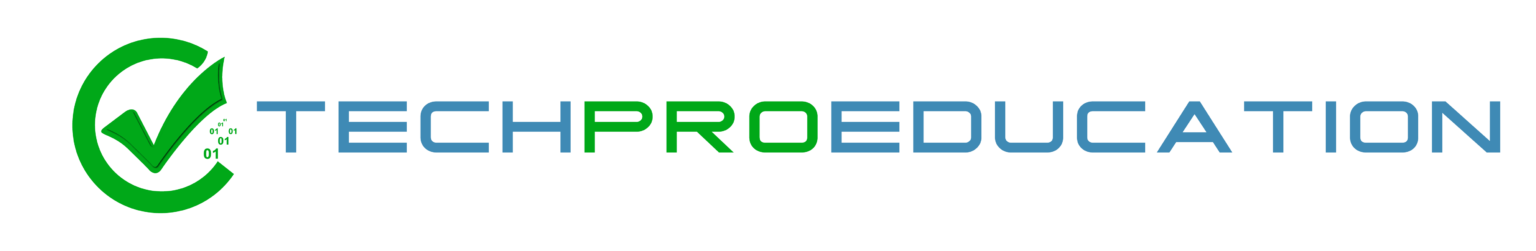

# WELCOME!

**Overview**

The data has been split into two groups:

- training set (train.csv)
- test set (test.csv)

**The training set** should be used to build your machine learning models. For the training set, we provide the outcome (also known as the “ground truth”) for each passenger. Your model will be based on “features” like passengers’ gender and class. You can also use feature engineering to create new features.

**The test set** should be used to see how well your model performs on unseen data. For the test set, we do not provide the ground truth for each passenger. It is your job to predict these outcomes. For each passenger in the test set, use the model you trained to predict whether or not they survived the sinking of the Titanic.

We also include gender_submission.csv, a set of predictions that assume all and only female passengers survive, as an example of what a submission file should look like.

**Data Dictionary**

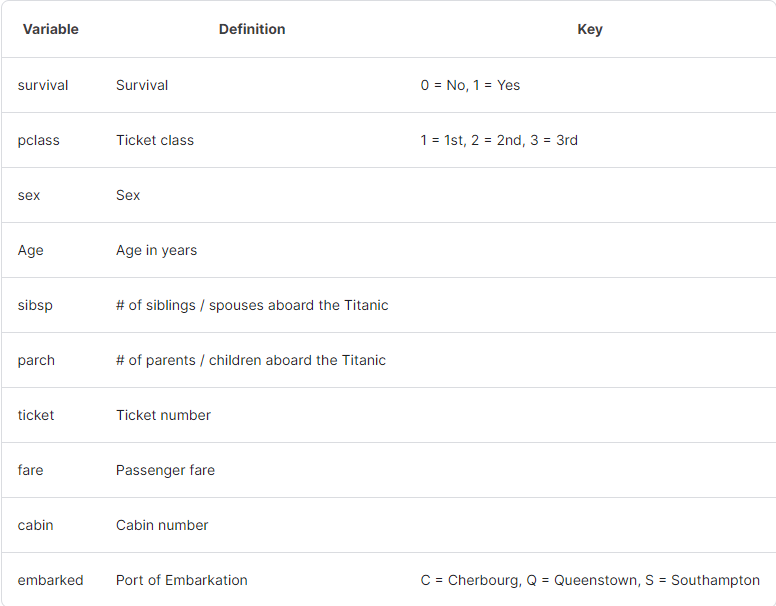

**Variable Notes**

pclass: A proxy for socio-economic status (SES)

1st = Upper

2nd = Middle

3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...

Sibling = brother, sister, stepbrother, stepsister

Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...

Parent = mother, father

Child = daughter, son, stepdaughter, stepson

Some children travelled only with a nanny, therefore parch=0 for them.

# Exploratory Data Analysis and Visualization

In [1]:
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.metrics import precision_recall_curve,roc_curve, auc, roc_auc_score

from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.tree import plot_tree


plt.rcParams["figure.figsize"] = (5,3.5)

warnings.filterwarnings("ignore")
warnings.warn("this will not show")

In [2]:
data = pd.read_csv('train.csv')
df = data.copy()

In [3]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
df.describe().T.style.background_gradient(cmap='PiYG', axis=1)

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.000000,446.000000,257.353842,1.000000,223.500000,446.000000,668.500000,891.000000
Survived,891.000000,0.383838,0.486592,0.000000,0.000000,0.000000,1.000000,1.000000
Pclass,891.000000,2.308642,0.836071,1.000000,2.000000,3.000000,3.000000,3.000000
Age,714.000000,29.699118,14.526497,0.420000,20.125000,28.000000,38.000000,80.000000
SibSp,891.000000,0.523008,1.102743,0.000000,0.000000,0.000000,1.000000,8.000000
Parch,891.000000,0.381594,0.806057,0.000000,0.000000,0.000000,0.000000,6.000000
Fare,891.000000,32.204208,49.693429,0.000000,7.910400,14.454200,31.000000,512.329200


In [6]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [7]:
missing_values = df.isnull().sum()

missing_percentages = (missing_values / len(df)) * 100

missing_data = pd.DataFrame({'Values': missing_values, 'Percentage (%)': missing_percentages})

print(missing_data)

             Values  Percentage (%)
PassengerId       0        0.000000
Survived          0        0.000000
Pclass            0        0.000000
Name              0        0.000000
Sex               0        0.000000
Age             177       19.865320
SibSp             0        0.000000
Parch             0        0.000000
Ticket            0        0.000000
Fare              0        0.000000
Cabin           687       77.104377
Embarked          2        0.224467


<AxesSubplot:>

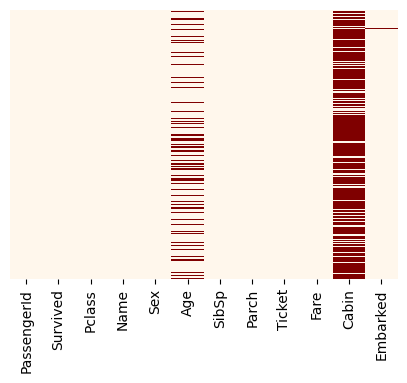

In [8]:
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='OrRd')

In [9]:
df.duplicated().any()

False

In [10]:
df.sample(15)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
688,689,0,3,"Fischer, Mr. Eberhard Thelander",male,18.0,0,0,350036,7.7958,NaN,S
734,735,0,2,"Troupiansky, Mr. Moses Aaron",male,23.0,0,0,233639,13.0000,NaN,S
349,350,0,3,"Dimic, Mr. Jovan",male,42.0,0,0,315088,8.6625,NaN,S
285,286,0,3,"Stankovic, Mr. Ivan",male,33.0,0,0,349239,8.6625,NaN,C
639,640,0,3,"Thorneycroft, Mr. Percival",male,NaN,1,0,376564,16.1000,NaN,S
743,744,0,3,"McNamee, Mr. Neal",male,24.0,1,0,376566,16.1000,NaN,S
521,522,0,3,"Vovk, Mr. Janko",male,22.0,0,0,349252,7.8958,NaN,S
620,621,0,3,"Yasbeck, Mr. Antoni",male,27.0,1,0,2659,14.4542,NaN,C
81,82,1,3,"Sheerlinck, Mr. Jan Baptist",male,29.0,0,0,345779,9.5000,NaN,S
705,706,0,2,"Morley, Mr. Henry Samuel (""Mr Henry Marshall"")",male,39.0,0,0,250655,26.0000,NaN,S


In [11]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [12]:
df.drop(["Name","Ticket","Cabin"],axis=1,inplace=True)

In [13]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Sex              0
Age            177
SibSp            0
Parch            0
Fare             0
Embarked         2
dtype: int64

In [14]:
df.duplicated().any()

False

In [15]:
df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S


In [16]:
df.Survived.value_counts()

0    549
1    342
Name: Survived, dtype: int64

## Pclass

In [17]:
df.groupby('Survived').Pclass.value_counts()

Survived  Pclass
0         3         372
          2          97
          1          80
1         1         136
          3         119
          2          87
Name: Pclass, dtype: int64

## Sex

In [18]:
df.groupby('Survived').Sex.value_counts()

Survived  Sex   
0         male      468
          female     81
1         female    233
          male      109
Name: Sex, dtype: int64

## Sipsp

In [19]:
df.groupby('Survived').SibSp.value_counts()

Survived  SibSp
0         0        398
          1         97
          2         15
          4         15
          3         12
          8          7
          5          5
1         0        210
          1        112
          2         13
          3          4
          4          3
Name: SibSp, dtype: int64

## Parch

In [20]:
df.groupby('Survived').Parch.value_counts()

Survived  Parch
0         0        445
          1         53
          2         40
          4          4
          5          4
          3          2
          6          1
1         0        233
          1         65
          2         40
          3          3
          5          1
Name: Parch, dtype: int64

## Embarked

Boarded passengers grouped by port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton):
S    644
C    168
Q     77
Name: Embarked, dtype: int64


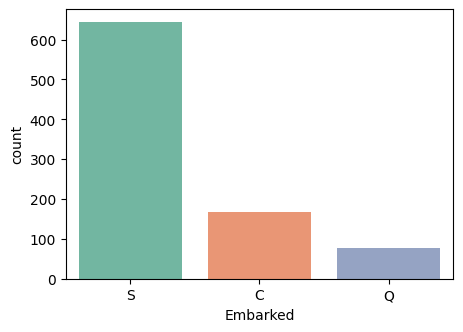

In [21]:
print('Boarded passengers grouped by port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton):')
print(df['Embarked'].value_counts())

sns.countplot(x='Embarked', data = df, palette = 'Set2')
plt.show()

In [22]:
#By far the most passengers boarded in Southhampton, so we'll impute those 2 NaN's w/ "S".
print('The most common boarding port of embarkation is %s.' %df['Embarked'].value_counts().idxmax())

The most common boarding port of embarkation is S.


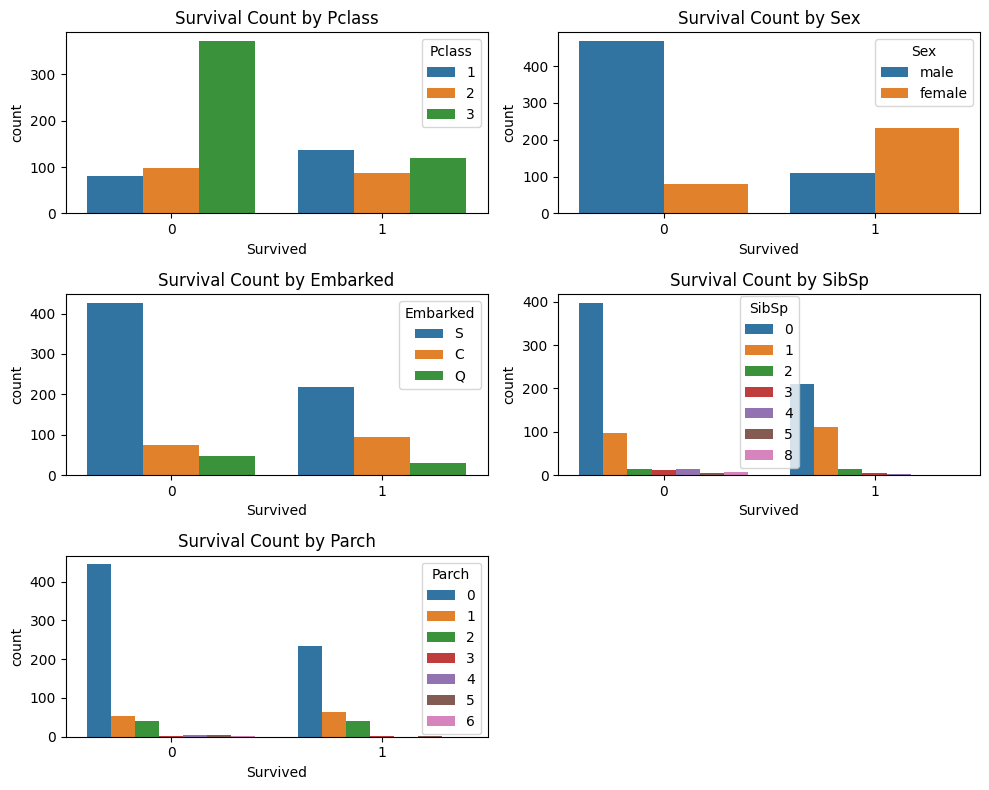

In [23]:
plt.figure(figsize=(10,8))

plt.subplot(321)
sns.countplot(data=df, x='Survived', hue='Pclass')
plt.title('Survival Count by Pclass')
plt.xlabel('Survived')

plt.subplot(322)
sns.countplot(data=df, x='Survived', hue='Sex')
plt.title('Survival Count by Sex')
plt.xlabel('Survived')

plt.subplot(323)
sns.countplot(data=df, x='Survived', hue='Embarked')
plt.title('Survival Count by Embarked')
plt.xlabel('Survived')

plt.subplot(324)
sns.countplot(data=df, x='Survived', hue='SibSp')
plt.title('Survival Count by SibSp')
plt.xlabel('Survived')

plt.subplot(325)
sns.countplot(data=df, x='Survived', hue='Parch')
plt.title('Survival Count by Parch')
plt.xlabel('Survived')

plt.tight_layout()
plt.show()

## Outlier

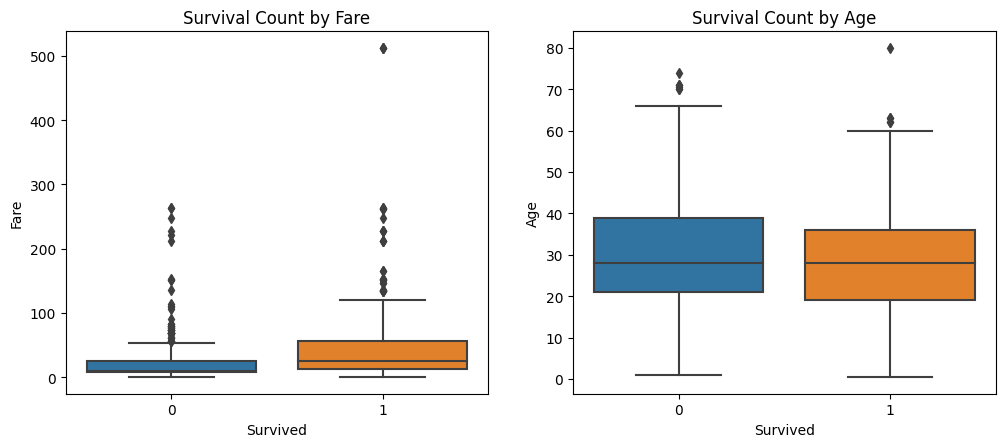

In [24]:
plt.figure(figsize=(12,16))

plt.subplot(321)
sns.boxplot(data=df, x='Survived', y='Fare')
plt.title('Survival Count by Fare')
plt.xlabel('Survived')

plt.subplot(322)
sns.boxplot(data=df, x='Survived', y='Age')
plt.title('Survival Count by Age')
plt.xlabel('Survived')

plt.show()

In [25]:
df['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

In [26]:
df[df['Fare'] >= 250].sort_values('Fare',ascending = False)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
258,259,1,1,female,35.0,0,0,512.3292,C
679,680,1,1,male,36.0,0,1,512.3292,C
737,738,1,1,male,35.0,0,0,512.3292,C
27,28,0,1,male,19.0,3,2,263.0000,S
88,89,1,1,female,23.0,3,2,263.0000,S
341,342,1,1,female,24.0,3,2,263.0000,S
438,439,0,1,male,64.0,1,4,263.0000,S
311,312,1,1,female,18.0,2,2,262.3750,C
742,743,1,1,female,21.0,2,2,262.3750,C


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


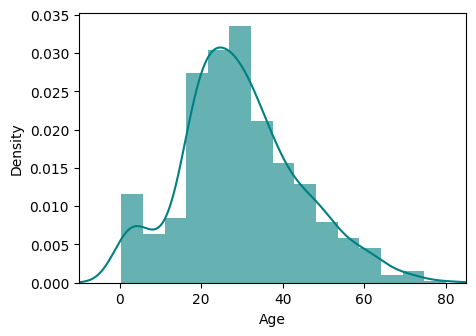

In [27]:
ax = df["Age"].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
df["Age"].plot(kind='density', color='teal')
ax.set(xlabel='Age')
plt.xlim(-10,85)
plt.show()

## Encoder

In [28]:
df.select_dtypes(include='object').columns

Index(['Sex', 'Embarked'], dtype='object')

In [29]:
le = LabelEncoder()

encoded_col_1 = le.fit_transform(df['Sex'])
encoded_col_2 = le.fit_transform(df['Embarked'])

df['Sex_encoded'] = encoded_col_1
df['Embarked_encoded'] = encoded_col_2

In [30]:
df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Sex_encoded,Embarked_encoded
0,1,0,3,male,22.0,1,0,7.2500,S,1,2
1,2,1,1,female,38.0,1,0,71.2833,C,0,0
2,3,1,3,female,26.0,0,0,7.9250,S,0,2
3,4,1,1,female,35.0,1,0,53.1000,S,0,2
4,5,0,3,male,35.0,0,0,8.0500,S,1,2


In [31]:
df.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_encoded,Embarked_encoded
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658,0.042939,0.013083
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307,-0.543351,-0.163517
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500,0.131900,0.157112
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067,0.093254,-0.025252
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651,-0.114631,0.066654
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225,-0.245489,0.038322
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000,-0.182333,-0.221226
Sex_encoded,0.042939,-0.543351,0.131900,0.093254,-0.114631,-0.245489,-0.182333,1.000000,0.104057
Embarked_encoded,0.013083,-0.163517,0.157112,-0.025252,0.066654,0.038322,-0.221226,0.104057,1.000000


<AxesSubplot:>

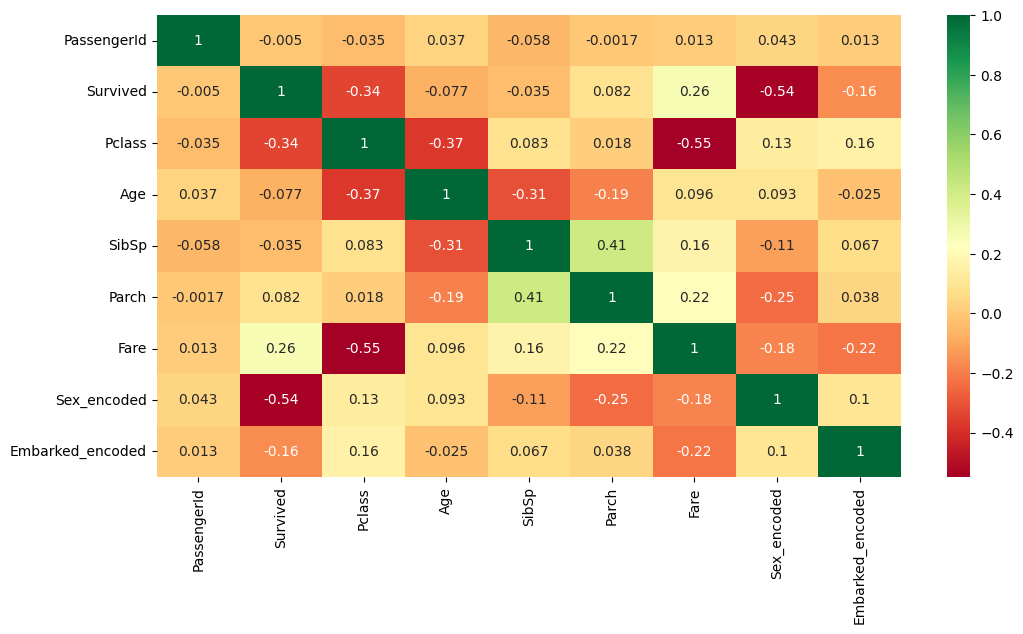

In [32]:
plt.figure(figsize = (12,6))
sns.heatmap(df.corr(),annot=True,cmap = 'RdYlGn')

## Train Test Split

In [33]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
       'Fare', 'Embarked', 'Sex_encoded', 'Embarked_encoded'],
      dtype='object')

In [34]:
X = df[['Pclass','SibSp','Parch','Sex_encoded','Fare','Embarked_encoded']]
y = df['Survived']

In [35]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

# AdaBoosting Classifier

In [36]:
adaboost_model = AdaBoostClassifier(n_estimators = 50,random_state = 0)

In [37]:
adaboost_model.fit(X_train,y_train)

AdaBoostClassifier(random_state=0)

In [38]:
def eval_metric(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_pred = model.predict(X_test)
    
    print("Test_Set")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print()
    print("Train_Set")
    print(confusion_matrix(y_train, y_train_pred))
    print(classification_report(y_train, y_train_pred))

In [39]:
eval_metric(adaboost_model,X_train,y_train,X_test,y_test)

Test_Set
[[94 16]
 [18 51]]
              precision    recall  f1-score   support

           0       0.84      0.85      0.85       110
           1       0.76      0.74      0.75        69

    accuracy                           0.81       179
   macro avg       0.80      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179


Train_Set
[[384  55]
 [ 79 194]]
              precision    recall  f1-score   support

           0       0.83      0.87      0.85       439
           1       0.78      0.71      0.74       273

    accuracy                           0.81       712
   macro avg       0.80      0.79      0.80       712
weighted avg       0.81      0.81      0.81       712



In [40]:
model = AdaBoostClassifier(n_estimators=50, random_state=42)

scores = cross_validate(model, X_train, y_train, scoring = ["accuracy", "precision", "recall", "f1"], cv = 10)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_accuracy     0.796479
test_precision    0.762612
test_recall       0.685185
test_f1           0.719646
dtype: float64

In [41]:
model= AdaBoostClassifier(n_estimators=3 , random_state = 0)
model.fit(X_train,y_train)

AdaBoostClassifier(n_estimators=3, random_state=0)

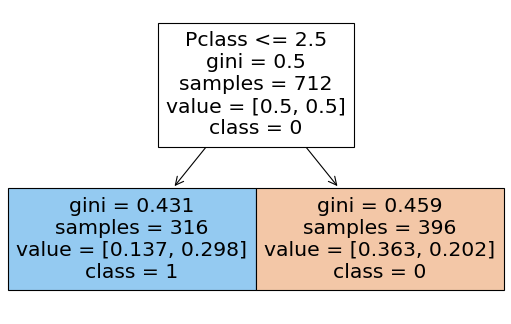

In [42]:
features = list(X.columns)
targets = df["Survived"].astype("str")

plt.figure(figsize=(8,5),dpi=80)
plot_tree(model.estimators_[1], filled=True, feature_names=X.columns, class_names=targets.unique());

## Analyzing performance

In [43]:
error_rates = []

for n in range(1,100):
    
    model = AdaBoostClassifier(n_estimators=n)
    model.fit(X_train,y_train)
    preds = model.predict(X_test)
    err = 1 - f1_score(y_test,preds)
    
    error_rates.append(err)


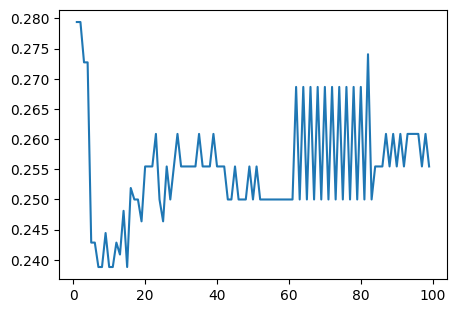

In [44]:
plt.plot(range(1,100), error_rates);

### HalvingGridSearchCV

In [45]:
model = AdaBoostClassifier(random_state = 0)

In [46]:
param_grid = { 'n_estimators' : [10,20,30,45,65,70,80,90,100],'learning_rate':[0.01,0.1,0.2,0.5,1.0]}

In [47]:
ada_grid_model = HalvingGridSearchCV (model,param_grid,cv = 5, scoring = 'f1')

In [48]:
ada_grid_model.fit(X_train,y_train)

HalvingGridSearchCV(estimator=AdaBoostClassifier(random_state=0),
                    param_grid={'learning_rate': [0.01, 0.1, 0.2, 0.5, 1.0],
                                'n_estimators': [10, 20, 30, 45, 65, 70, 80, 90,
                                                 100]},
                    scoring='f1')

In [49]:
ada_grid_model.best_params_

{'learning_rate': 0.1, 'n_estimators': 80}

In [50]:
ada_grid_model.best_score_

0.7117964875038513

In [51]:
y_pred = ada_grid_model.predict(X_test)

adaboost_f1 = f1_score(y_test, y_pred)
adaboost_recall = recall_score(y_test, y_pred)
adaboost_auc = roc_auc_score(y_test, y_pred)
eval_metric(ada_grid_model, X_train, y_train, X_test, y_test)

Test_Set
[[97 13]
 [21 48]]
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       110
           1       0.79      0.70      0.74        69

    accuracy                           0.81       179
   macro avg       0.80      0.79      0.79       179
weighted avg       0.81      0.81      0.81       179


Train_Set
[[392  47]
 [ 90 183]]
              precision    recall  f1-score   support

           0       0.81      0.89      0.85       439
           1       0.80      0.67      0.73       273

    accuracy                           0.81       712
   macro avg       0.80      0.78      0.79       712
weighted avg       0.81      0.81      0.80       712



## Feauture Importances

In [52]:
model = AdaBoostClassifier(n_estimators = 30, learning_rate = 0.2, random_state = 0)
model.fit(X_train, y_train)
model.feature_importances_

feats = pd.DataFrame(index=X.columns, data= model.feature_importances_, columns=['ada_importance'])
adaboost_imp_feats = feats.sort_values("ada_importance")
adaboost_imp_feats

,ada_importance
Embarked_encoded,0.033333
Parch,0.066667
SibSp,0.100000
Pclass,0.166667
Fare,0.266667
Sex_encoded,0.366667


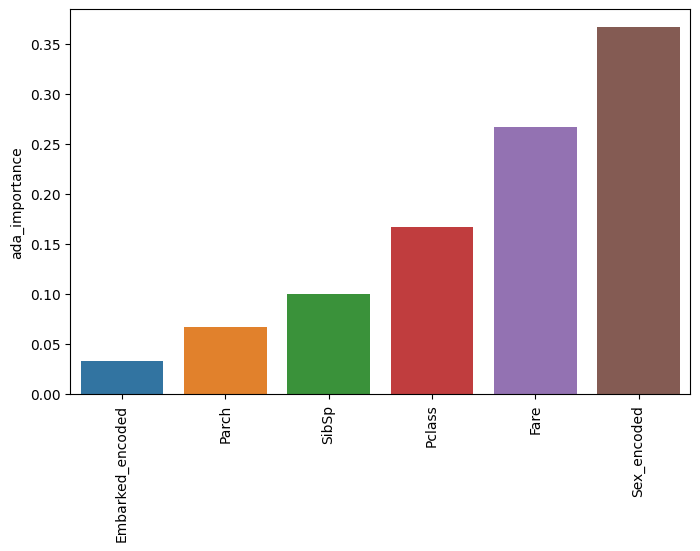

In [53]:
plt.figure(figsize=(8,5))
sns.barplot(data = adaboost_imp_feats ,x = adaboost_imp_feats.index, y='ada_importance')

plt.xticks(rotation=90)
plt.show()

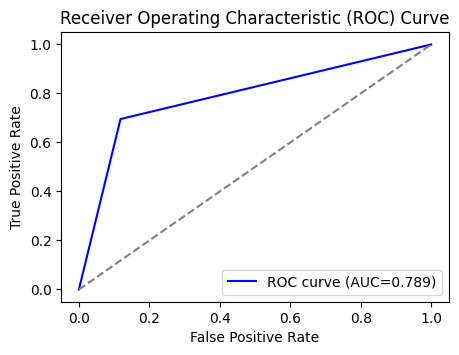

In [54]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

auc_score = roc_auc_score(y_test, y_pred)

plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC={auc_score:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

plt.show()

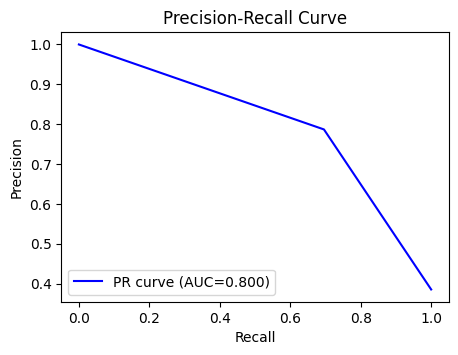

In [55]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

auc_score = auc(recall, precision)

plt.plot(recall, precision, color='blue', label=f'PR curve (AUC={auc_score:.3f})')

plt.xlabel('Recall')
plt.ylabel('Precision')

plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')

plt.show()

# GradientBoosting Classifier

In [56]:
X.head()

,Pclass,SibSp,Parch,Sex_encoded,Fare,Embarked_encoded
0,3,1,0,1,7.2500,2
1,1,1,0,0,71.2833,0
2,3,0,0,0,7.9250,2
3,1,1,0,0,53.1000,2
4,3,0,0,1,8.0500,2


In [57]:
grad_model = GradientBoostingClassifier(random_state = 0)

In [58]:
grad_model.fit(X_train,y_train)

GradientBoostingClassifier(random_state=0)

In [59]:
eval_metric(grad_model,X_train,y_train,X_test,y_test)

Test_Set
[[101   9]
 [ 20  49]]
              precision    recall  f1-score   support

           0       0.83      0.92      0.87       110
           1       0.84      0.71      0.77        69

    accuracy                           0.84       179
   macro avg       0.84      0.81      0.82       179
weighted avg       0.84      0.84      0.83       179


Train_Set
[[415  24]
 [ 74 199]]
              precision    recall  f1-score   support

           0       0.85      0.95      0.89       439
           1       0.89      0.73      0.80       273

    accuracy                           0.86       712
   macro avg       0.87      0.84      0.85       712
weighted avg       0.87      0.86      0.86       712



In [60]:
model = GradientBoostingClassifier(random_state = 0)

scores = cross_validate(model, X_train, y_train, scoring = ['accuracy', 'precision','recall',
                                                                   'f1', 'roc_auc'], cv = 5)
df_scores = pd.DataFrame(scores, index = range(1, 6))
df_scores.mean()[2:]

test_accuracy     0.785049
test_precision    0.754406
test_recall       0.651717
test_f1           0.699153
test_roc_auc      0.830488
dtype: float64

### HalvingGridSearchCV

In [61]:
param_grid = { 'n_estimators':[100,200,300],
              'subsample':[0.5,1],'max_features' :[None,2,3,4,5]}

In [62]:
gb_model = GradientBoostingClassifier(random_state = 0)

In [63]:
gb_grid_model = HalvingGridSearchCV(gb_model,param_grid,scoring='f1',verbose=2 , n_jobs=-1)

In [64]:
gb_grid_model.fit(X_train,y_train)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 26
max_resources_: 712
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 30
n_resources: 26
Fitting 5 folds for each of 30 candidates, totalling 150 fits
----------
iter: 1
n_candidates: 10
n_resources: 78
Fitting 5 folds for each of 10 candidates, totalling 50 fits
----------
iter: 2
n_candidates: 4
n_resources: 234
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 3
n_candidates: 2
n_resources: 702
Fitting 5 folds for each of 2 candidates, totalling 10 fits


HalvingGridSearchCV(estimator=GradientBoostingClassifier(random_state=0),
                    n_jobs=-1,
                    param_grid={'max_features': [None, 2, 3, 4, 5],
                                'n_estimators': [100, 200, 300],
                                'subsample': [0.5, 1]},
                    scoring='f1', verbose=2)

In [65]:
gb_grid_model.best_params_

{'max_features': 3, 'n_estimators': 100, 'subsample': 0.5}

In [66]:
gb_grid_model.best_estimator_

GradientBoostingClassifier(max_features=3, random_state=0, subsample=0.5)

In [67]:
gb_grid_model.best_score_

0.7085932123840812

In [68]:
y_pred = gb_grid_model.predict(X_test)

gb_f1 = f1_score(y_test, y_pred)
gb_recall = recall_score(y_test, y_pred)
gb_auc = roc_auc_score(y_test, y_pred)

eval_metric(gb_grid_model, X_train, y_train, X_test, y_test)

Test_Set
[[100  10]
 [ 23  46]]
              precision    recall  f1-score   support

           0       0.81      0.91      0.86       110
           1       0.82      0.67      0.74        69

    accuracy                           0.82       179
   macro avg       0.82      0.79      0.80       179
weighted avg       0.82      0.82      0.81       179


Train_Set
[[412  27]
 [ 80 193]]
              precision    recall  f1-score   support

           0       0.84      0.94      0.89       439
           1       0.88      0.71      0.78       273

    accuracy                           0.85       712
   macro avg       0.86      0.82      0.83       712
weighted avg       0.85      0.85      0.85       712



## Feature Importance

In [69]:
model = GradientBoostingClassifier(max_features= 2, n_estimators = 100, subsample = 1, random_state = 0)
model.fit(X_train, y_train)

model.feature_importances_

feats = pd.DataFrame(index = X.columns, data=model.feature_importances_, columns=['grad_importance'])
grad_imp_feats = feats.sort_values("grad_importance")
grad_imp_feats

,grad_importance
Embarked_encoded,0.024463
SibSp,0.046687
Parch,0.049987
Pclass,0.138307
Fare,0.227902
Sex_encoded,0.512654


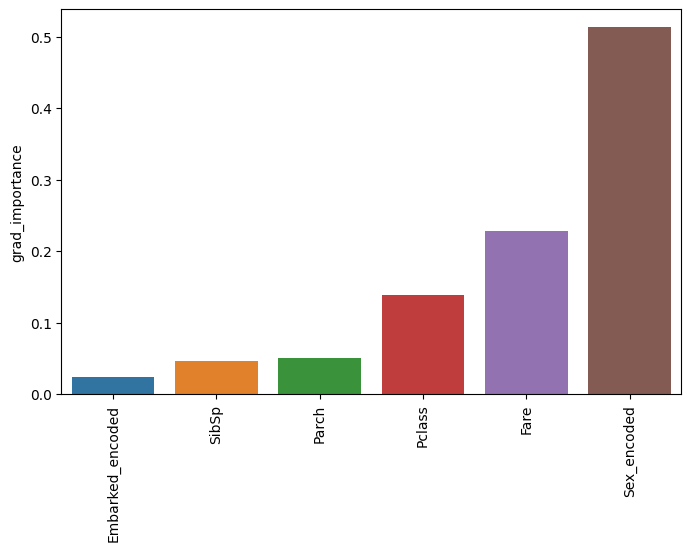

In [70]:
plt.figure(figsize=(8,5))
sns.barplot(data=grad_imp_feats, x=grad_imp_feats.index, y='grad_importance')

plt.xticks(rotation=90)
plt.show()

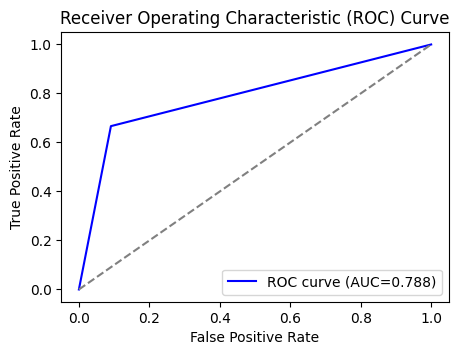

In [71]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

auc_score = roc_auc_score(y_test, y_pred)

plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC={auc_score:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

plt.show()

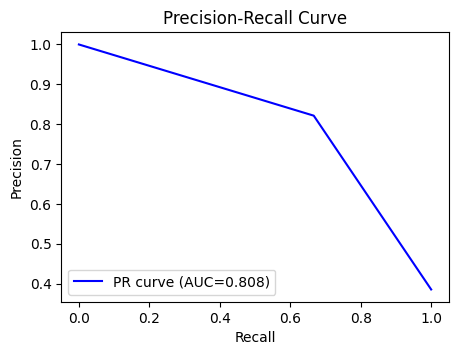

In [72]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

auc_score = auc(recall, precision)

plt.plot(recall, precision, color='blue', label=f'PR curve (AUC={auc_score:.3f})')

plt.xlabel('Recall')
plt.ylabel('Precision')

plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')

plt.show()

# XGBoosting Classifier

In [73]:
xgb_model = XGBClassifier(random_state = 0)

In [74]:
xgb_model.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=0, ...)

In [75]:
eval_metric(xgb_model,X_train,y_train,X_test,y_test)

Test_Set
[[97 13]
 [20 49]]
              precision    recall  f1-score   support

           0       0.83      0.88      0.85       110
           1       0.79      0.71      0.75        69

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.82      0.81       179


Train_Set
[[421  18]
 [ 40 233]]
              precision    recall  f1-score   support

           0       0.91      0.96      0.94       439
           1       0.93      0.85      0.89       273

    accuracy                           0.92       712
   macro avg       0.92      0.91      0.91       712
weighted avg       0.92      0.92      0.92       712



In [76]:
model = xgb.XGBClassifier(random_state=0, verbosity=0)

In [77]:
scores = cross_validate(model,X_train,y_train,scoring=['accuracy','precision','recall','f1','roc_auc'],cv = 10)

In [78]:
df_scores = pd.DataFrame(scores,index = range(1,11))
df_scores.mean()[2:]

test_accuracy     0.785074
test_precision    0.745703
test_recall       0.673545
test_f1           0.704251
test_roc_auc      0.830542
dtype: float64

## GridSearch

In [79]:
param_grid = {
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300],
    'subsample': [0.5, 1],
    'max_features': [None, 2, 3, 5]
}

In [80]:
xgb_model = xgb.XGBClassifier(random_state = 0, verbosity = 0)

In [81]:
xgb_grid_model = GridSearchCV(xgb_model, param_grid, scoring='f1', verbose=2, n_jobs=-1)

In [82]:
xgb_grid_model.fit(X_train,y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_b...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=0, ...),
             n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7],
                         'max_features': [None, 2, 3, 5],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.5, 1]},
             scoring='f1', verbose=2)

In [83]:
xgb_grid_model.best_params_

{'max_depth': 3, 'max_features': None, 'n_estimators': 100, 'subsample': 0.5}

In [84]:
xgb_grid_model.best_score_

0.7247283141419576

In [85]:
y_pred = xgb_grid_model.predict(X_test)

In [86]:
xgb_f1 = f1_score(y_test, y_pred)
xgb_recall = recall_score(y_test, y_pred)
xgb_auc = roc_auc_score(y_test, y_pred)

eval_metric(xgb_grid_model, X_train, y_train, X_test, y_test)

Test_Set
[[96 14]
 [21 48]]
              precision    recall  f1-score   support

           0       0.82      0.87      0.85       110
           1       0.77      0.70      0.73        69

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179


Train_Set
[[413  26]
 [ 66 207]]
              precision    recall  f1-score   support

           0       0.86      0.94      0.90       439
           1       0.89      0.76      0.82       273

    accuracy                           0.87       712
   macro avg       0.88      0.85      0.86       712
weighted avg       0.87      0.87      0.87       712



## Feature Importance

In [87]:
model = XGBClassifier(random_state=42, n_estimators = 60,colsample_bytree = 0.4, subsample= 0.5,learning_rate = 0.2,max_depth= 5)
model.fit(X_train, y_train)

model.feature_importances_

feats = pd.DataFrame(index=X.columns, data=model.feature_importances_, columns=['xgb_importance'])
xgb_imp_feats = feats.sort_values("xgb_importance")

xgb_imp_feats

,xgb_importance
SibSp,0.042844
Embarked_encoded,0.049656
Parch,0.053228
Fare,0.079225
Pclass,0.139182
Sex_encoded,0.635865


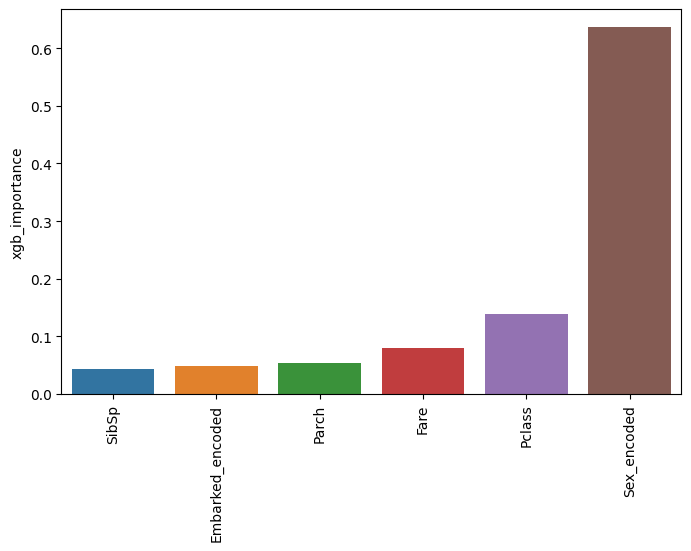

In [88]:
plt.figure(figsize=(8,5))
sns.barplot(data=xgb_imp_feats, x=xgb_imp_feats.index,y='xgb_importance')

plt.xticks(rotation=90)
plt.show()

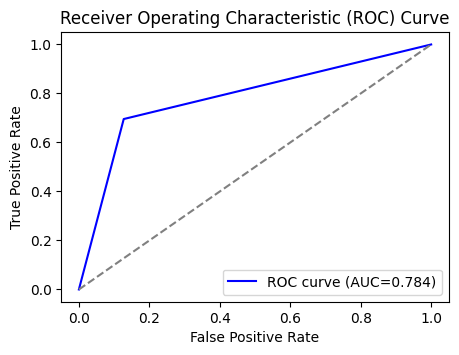

In [89]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)


auc_score = roc_auc_score(y_test, y_pred)


plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC={auc_score:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

plt.show()

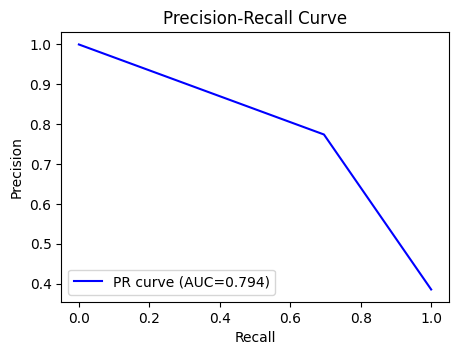

In [90]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)


auc_score = auc(recall, precision)


plt.plot(recall, precision, color='blue', label=f'PR curve (AUC={auc_score:.3f})')

plt.xlabel('Recall')
plt.ylabel('Precision')

plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')

plt.show()

## Comparing Models

In [91]:
pd.concat([adaboost_imp_feats, grad_imp_feats, xgb_imp_feats], axis=1)

,ada_importance,grad_importance,xgb_importance
Embarked_encoded,0.033333,0.024463,0.049656
Parch,0.066667,0.049987,0.053228
SibSp,0.100000,0.046687,0.042844
Pclass,0.166667,0.138307,0.139182
Fare,0.266667,0.227902,0.079225
Sex_encoded,0.366667,0.512654,0.635865


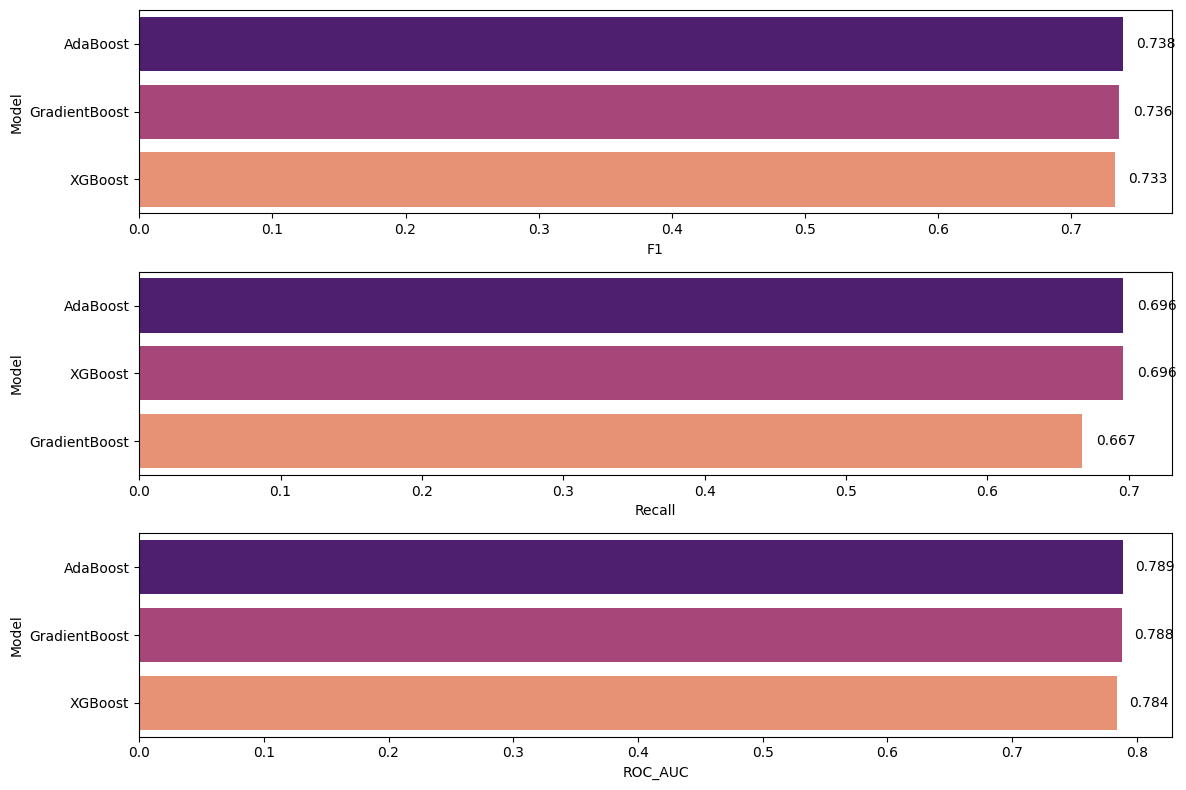

In [92]:
compare = pd.DataFrame({"Model": ["AdaBoost","GradientBoost", "XGBoost"],
                        "F1": [adaboost_f1, gb_f1, xgb_f1],
                        "Recall": [adaboost_recall, gb_recall, xgb_recall],
                        "ROC_AUC": [adaboost_auc, gb_auc, xgb_auc]})

def labels(ax):
    for p in ax.patches:
        width = p.get_width()                         # çubuğun uzunluğunu al
        ax.text(width + 0.01,                         # metni çubuğun 0.01 birim sağında konumlandır.
                p.get_y() + p.get_height() / 2,       # Y koordinatını al + X koordinatı / 2
                '{:1.3f}'.format(width),              # gösterilecek değişkeni 2 ondalık basamaklı olarak ayarla
                ha='left',                            # yatay hizalama
                va='center')                          # dikey hizalama


plt.figure(figsize=(12, 8))

plt.subplot(311)
compare = compare.sort_values(by="F1", ascending=False)
ax = sns.barplot(x="F1", y="Model", data=compare, palette="magma")
labels(ax)

plt.subplot(312)
compare = compare.sort_values(by="Recall", ascending=False)
ax = sns.barplot(x="Recall", y="Model", data=compare, palette="magma")
labels(ax)

plt.subplot(313)
compare = compare.sort_values(by="ROC_AUC", ascending=False)
ax = sns.barplot(x="ROC_AUC", y="Model", data=compare, palette="magma")
labels(ax)

plt.tight_layout()
plt.show()

## Conclusion

##### Scores say that we should choose the Ada Boost model, but before taking a decision let see how the scores will change if we use only 2 features.

In [93]:
X2 = df[['Pclass','Sex_encoded']]
y2 = df['Survived']

In [94]:
X_train,X_test,y_train,y_test = train_test_split(X2, y2, test_size= 0.20,random_state=42)

In [95]:
model_new = AdaBoostClassifier(random_state=42)

In [96]:
param_grid = { 'n_estimators' : [10,20,30,45,65,70,80,90,100],'learning_rate':[0.01,0.1,0.2,0.5,1.0]}

In [97]:
ada_grid_model2 = GridSearchCV(model_new,param_grid,cv = 5,scoring='f1')

In [98]:
ada_grid_model2.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=AdaBoostClassifier(random_state=42),
             param_grid={'learning_rate': [0.01, 0.1, 0.2, 0.5, 1.0],
                         'n_estimators': [10, 20, 30, 45, 65, 70, 80, 90, 100]},
             scoring='f1')

In [99]:
ada_grid_model2.best_params_

{'learning_rate': 0.01, 'n_estimators': 10}

In [100]:
y_pred = ada_grid_model2.predict(X_test)

ada_f1_2 = f1_score(y_test, y_pred)
ada_recall_2 = recall_score(y_test, y_pred)
ada_auc_2 = roc_auc_score(y_test, y_pred)
eval_metric(ada_grid_model2, X_train, y_train, X_test, y_test)

print('*' * 50)
print('{:<20}{}'.format('f1:', ada_f1_2))
print('*' * 50)
print('{:<20}{}'.format('Recall:', ada_recall_2))
print('*' * 50)
print('{:<20}{}'.format('Roc_Auc:', ada_auc_2))
print('*' * 50)

Test_Set
[[88 17]
 [22 52]]
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       105
           1       0.75      0.70      0.73        74

    accuracy                           0.78       179
   macro avg       0.78      0.77      0.77       179
weighted avg       0.78      0.78      0.78       179


Train_Set
[[380  64]
 [ 87 181]]
              precision    recall  f1-score   support

           0       0.81      0.86      0.83       444
           1       0.74      0.68      0.71       268

    accuracy                           0.79       712
   macro avg       0.78      0.77      0.77       712
weighted avg       0.79      0.79      0.79       712

**************************************************
f1:                 0.7272727272727273
**************************************************
Recall:             0.7027027027027027
**************************************************
Roc_Auc:            0.7703989703989704
**************

## Final Conclusion

#### With 2 features our Ada Boost model gets higher scores. 

In [101]:
X2 = df[['Pclass','Sex_encoded']]
y2 = df['Survived']

In [102]:
model_final = AdaBoostClassifier(n_estimators= 10,learning_rate=0.01)

In [103]:
model_final.fit(X2,y2)

AdaBoostClassifier(learning_rate=0.01, n_estimators=10)

In [104]:
test= pd.read_csv('test.csv')

In [105]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [106]:
le = LabelEncoder()

encoded_col_1 = le.fit_transform(test['Sex'])

test['Sex_encoded'] = encoded_col_1

In [107]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_encoded
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,1
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,0


In [108]:
X_test_new = test[['Pclass','Sex_encoded']]

In [109]:
final_predict=model_final.predict(X_test_new)
final_predict

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [110]:
gender_submission = pd.read_csv('gender_submission.csv')

In [111]:
gender_submission['predict'] = final_predict

In [112]:
gender_submission

,PassengerId,Survived,predict
0,892,0,0
1,893,1,1
2,894,0,0
3,895,0,0
4,896,1,1
...,...,...,...
413,1305,0,0
414,1306,1,1
415,1307,0,0
416,1308,0,0


In [113]:
gender_submission[gender_submission['Survived'] != gender_submission['predict']].count()

PassengerId    0
Survived       0
predict        0
dtype: int64

In [114]:
accuracy_score(gender_submission.Survived.values,final_predict)

1.0